**Background:**

We are one of the fastest growing startups in the logistics and delivery domain. We work with several partners and make on-demand delivery to our customers. During the COVID-19 pandemic, we are facing several different challenges and everyday we are trying to address these challenges.

We thrive on making our customers happy. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.

Getting feedback from customers is not easy either, but we do our best to get constant feedback from our customers. This is a crucial function to improve our operations across all levels.

We recently did a survey to a select customer cohort. You are presented with a subset of this data. We will be using the remaining data as a private test set.

**Data Description:**

* Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers
* X1 = my order was delivered on time
* X2 = contents of my order was as I expected
* X3 = I ordered everything I wanted to order
* X4 = I paid a good price for my order
* X5 = I am satisfied with my courier
* X6 = the app makes ordering easy for me 

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer. 

**Goal(s):**

* Predict if a customer is happy or not based on the answers they give to questions asked.

**Success Metrics:**

* Reach 73% accuracy score or above, or convince us why your solution is superior. We are definitely interested in every solution and insight you can provide us.
* Try to submit your working solution as soon as possible. The sooner the better. 

**Data exploration and features engineering**

In [33]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import chi2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm, metrics
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [34]:
df = pd.read_csv('HappinessSurvey2020.csv')

In [35]:
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [37]:
df.describe(include="all")

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


happy: Y    69
dtype: int64
unhappy: Y    57
dtype: int64


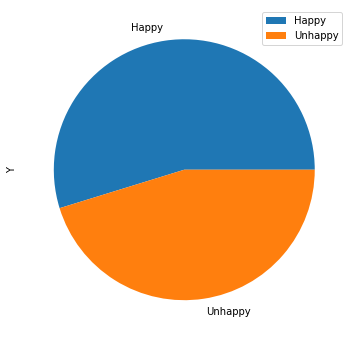

In [62]:
happy= df.loc[df['Y'] ==1]
unhappy= df.loc[df['Y']==0]
happy= happy.iloc[:, :1]
happy= happy.sum()
unhappy= df.shape[0]- happy
p = [happy, unhappy]
plt_data = pd.DataFrame(p)
plt_data.plot(kind='pie', subplots=True, labels=['Happy', 'Unhappy'],figsize=(6,6))
print("happy:",happy)
print("unhappy:",unhappy)

Based on the graph , we can observe that the data is slight unbalanced(69-57=12)

In [39]:
# Putting feature variable to X
X = df.drop(['Y'], axis=1)
X.head()

,X1,X2,X3,X4,X5,X6
0,3,3,3,4,2,4
1,3,2,3,5,4,3
2,5,3,3,3,3,5
3,5,4,3,3,3,5
4,5,4,3,3,3,5


In [40]:
# puttting target variable to y
y = df['Y']

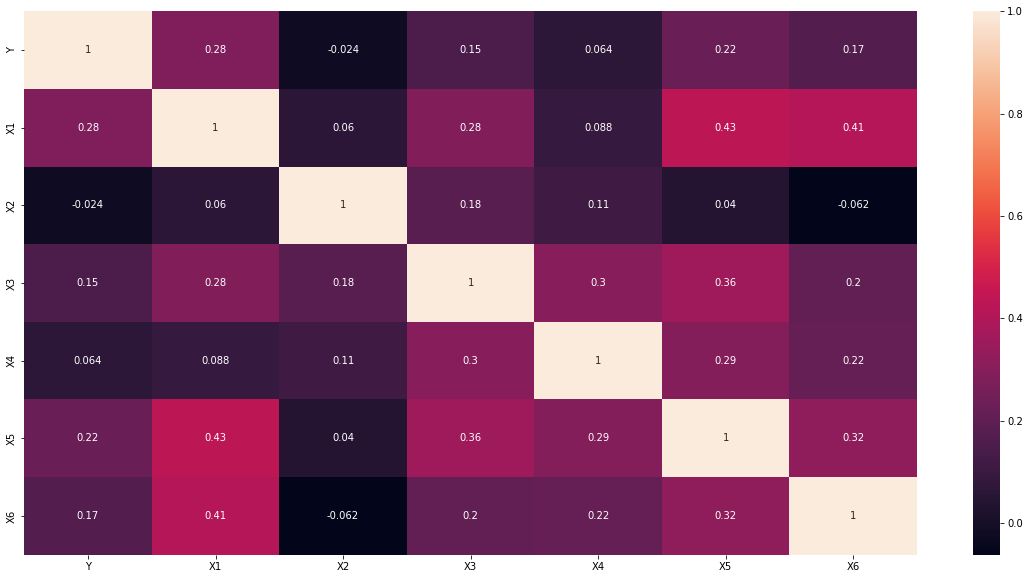

In [41]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(df.corr(),annot = True)
plt.show()

Based on the correlation matrix using heatmap, X1 and X5 are more correlated to the target variable

In [42]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)


**Using Logistic Regression**

In [43]:
# scalling the data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
# Make instance of the model
model = LogisticRegression()

In [45]:
model.fit(X_train, y_train)

LogisticRegression()

In [46]:
predictions = model.predict(X_test)

In [47]:
# Use score method to get accuracy of model
score = model.score(X_test, y_test)
print(score)

0.6842105263157895


In [48]:
confusion_matrix(y_test,predictions)

array([[10,  4],
       [ 8, 16]])

** mentor advice**
* features selection using chistq test
* cross validation
* check performance on training and test data
* use dummy variable on categorical data

**Feature Selection**

In [64]:
from sklearn.feature_selection import SelectKBest, chi2

Feature(0) X1: 1.221404
Feature(1) X2: 0.012054
Feature(2) X3: 0.489005
Feature(3) X4: 0.227263
Feature(4) X5: 0.997300
Feature(5) X6: 0.579710


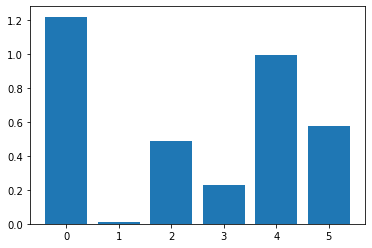

In [65]:
# feature selection
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# scores for features
feature_names = ['X1','X2','X3','X4','X5','X6']
for i in range(len(fs.scores_)):
    print('Feature(%d) %s: %f' % (i, feature_names[i], fs.scores_[i]))

# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

We can observe that features X5 and X1 are more corralated to the target variable

**Create the model and use cross validation**



*   Let first work with all features



In [66]:
def model_performance(Xlr,ylr):
    # Spot Check Algorithms
    models = []
    models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC(gamma='auto')))
    models.append(('RF', RandomForestClassifier(max_depth=6, random_state=100)))
    ratio = float(np.sum(ylr == 0)) / np.sum(ylr==1)
    models.append(('XGB', XGBClassifier(scale_pos_weight = ratio, learning_rate =0.01,
                        objective= 'binary:logistic', use_label_encoder=False, eval_metric='error')))

    # evaluate each model in turn
    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)
        cv_results = cross_val_score(model, Xlr, ylr, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        print('%s: %.2f (%.2f)' % (name, cv_results.mean()*100, cv_results.std()))
    _ = plt.bar(names,np.mean(results, axis=1)*100)

LR: 55.42 (0.12)
LDA: 54.31 (0.14)
KNN: 55.69 (0.09)
CART: 57.08 (0.18)
NB: 56.67 (0.14)
SVM: 52.08 (0.10)
RF: 56.81 (0.13)
XGB: 55.97 (0.19)


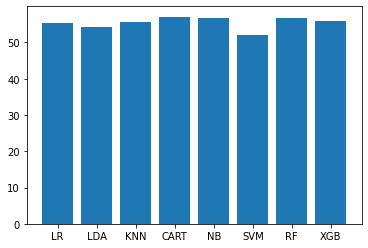

In [67]:
model_performance(X_train, y_train)

Now by just considering required features, lets evaluate above models again. Based on the feature scores, lets set the value of k=3.

In [68]:
# feature selection
def select_features_chi(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k=3)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [69]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# feature selection (chi2)
X_train_cfs, X_test_cfs, cfs = select_features_chi(X_train, y_train, X_test)

LR: 56.67 (0.13)
LDA: 56.53 (0.14)
KNN: 56.53 (0.10)
CART: 51.25 (0.13)
NB: 61.11 (0.12)
SVM: 50.83 (0.11)
RF: 52.36 (0.12)
XGB: 62.64 (0.15)


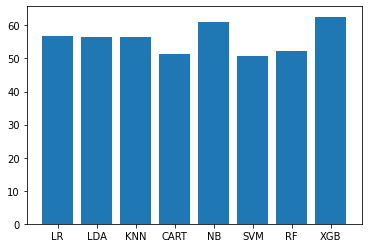

In [70]:
model_performance(X_train_cfs, y_train)

In [71]:
rfcModel = RandomForestClassifier(max_depth=6, random_state=100)
rfcModel.fit(X_train_cfs, y_train)
predictions = rfcModel.predict(X_test_cfs)

# Evaluate predictions
print('Testing Accuracy: %.2f \n' % (accuracy_score(y_test, predictions)*100))
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:\n')
print(classification_report(y_test, predictions))

Testing Accuracy: 73.68 

Confusion matrix:
[[12  5]
 [ 5 16]]

Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.71      0.71        17
           1       0.76      0.76      0.76        21

    accuracy                           0.74        38
   macro avg       0.73      0.73      0.73        38
weighted avg       0.74      0.74      0.74        38



In [72]:
ratio = float(np.sum(y_train == 0)) / np.sum(y_train==1)
xgbModel = XGBClassifier(scale_pos_weight = ratio, learning_rate =0.1,
                        objective= 'binary:logistic', use_label_encoder=False, eval_metric='error')
xgbModel.fit(X_train_cfs, y_train)
predictions = xgbModel.predict(X_test_cfs)

# Evaluate predictions
print('Testing Accuracy: %.2f \n' % (accuracy_score(y_test, predictions)*100))
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:\n')
print(classification_report(y_test, predictions))

Testing Accuracy: 73.68 

Confusion matrix:
[[13  4]
 [ 6 15]]

Classification Report:

              precision    recall  f1-score   support

           0       0.68      0.76      0.72        17
           1       0.79      0.71      0.75        21

    accuracy                           0.74        38
   macro avg       0.74      0.74      0.74        38
weighted avg       0.74      0.74      0.74        38



**Conclusion**


1.   Random Forest is performing slighly well: we have 52.36% as training accuracy and 73.68% on test data
2.   XG Boost is performing well: we have 62.64% as training accuracy and 73.68% on test data
3. For others algorithms, the test accuracy is smaller than the traning accuracy(more likely to be overfitting)
4. For perspective, we can add more data and remove X2 from next survey since the score was too low 

